In [1]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
    Resize, CenterCrop,
    ToPILImage,
    Normalize,
    RandomVerticalFlip,
    RandomRotation,
)

import torchvision.models as models
from torchvision import transforms

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [2]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.10.2+cu102
DEVICE: cuda


In [3]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    image_transform = Compose([
                ToPILImage(),
                Resize(255),
                CenterCrop(224),
                RandomResizedCrop(224),
                RandomGrayscale(p=0.2),
                RandomHorizontalFlip(p=0.5),
                RandomVerticalFlip(p = 0.5),
                RandomApply([ColorJitter(0.4, 0.4, 0.4, 0.2)], p=0.8),      # random color jitter
                RandomApply([ GaussianBlur(kernel_size=[21,21])], p=0.5),   
                ToTensor(),
                Normalize(mean= [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225], 
                          inplace = True),
                ])
    

    return image_transform


# generate two views for an image
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [5]:
labels = ['DC', 'LC', 'MC', 'PC', 'PT', 'F', 'TA', 'A']
labels.sort()
labelMap = {label: index for index, label in enumerate(labels)}
print(labelMap)

{'A': 0, 'DC': 1, 'F': 2, 'LC': 3, 'MC': 4, 'PC': 5, 'PT': 6, 'TA': 7}


In [6]:
class ContrastiveDataset(Dataset):

    def __init__(self, file_name, transform=None):
        
        self.list_images = []
        with open(file_name, 'r') as f:
            csvreader = csv.reader(f)
            for row in csvreader:
                self.list_images.append(row)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, index):
        img_name = self.list_images[index][0]
        image = io.imread(img_name)
        
        if self.transform:
            views = self.transform(image)
        return views
                

In [115]:
class ClassificationDataset(Dataset):
    def __init__(self, file_name, transform=None):
        self.list_images = []
       
        with open(file_name, 'r') as f:
            csvreader = csv.reader(f)
            for row in csvreader:
                self.list_images.append(row)
        self.transform = Compose([
            ToPILImage(),
            Resize(255),
            CenterCrop(224),          
            ToTensor(),
            transforms.RandomSolarize(1, p=0.5),
            transforms.RandomRotation(degrees=(0, 180)),
            Normalize(mean= [0.485, 0.456, 0.406], 
                      std = [0.229, 0.224, 0.225], 
                      inplace = True),
            ])
    
    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, index):
        img_name = self.list_images[index][0]
        image = io.imread(img_name)
        
        class_name = img_name.split('/')[-1].split('_')[2].split('-')[0]
        label = labelMap[class_name]
        
        if self.transform:
            class_image = self.transform(image)
        return class_image, label
    

In [116]:
base = '../Fold_1_5/'

In [117]:
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# base SimCLR data augmentation
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)

# The custom transform
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)


train_ds = ContrastiveDataset(
    file_name= base + 'train_80.csv',
    transform=custom_transform
)

valid_ds = ContrastiveDataset(
    file_name= base + 'val_20.csv',
    transform=custom_transform
)


In [118]:
class_train_ds = ClassificationDataset(
    file_name= base + 'train_80.csv',
)

class_valid_ds = ClassificationDataset(
    file_name= base + 'val_20.csv'
)


In [119]:
print(len(class_train_ds), len(class_valid_ds))

6327 1582


In [120]:
print((class_train_ds[140]))

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [121]:
print(len(train_ds), len(valid_ds))

6327 1582


In [122]:
print((train_ds[0]))


[tensor([[[1.5639, 1.4440, 1.2557,  ..., 1.4269, 1.3413, 1.3070],
         [1.5125, 1.4440, 1.2557,  ..., 1.4269, 1.3927, 1.3927],
         [1.5125, 1.4269, 1.2043,  ..., 1.4783, 1.5639, 1.5810],
         ...,
         [1.2385, 1.2557, 1.4612,  ..., 2.2489, 2.2318, 2.2318],
         [1.1872, 1.2385, 1.4098,  ..., 2.2489, 2.2489, 2.2489],
         [1.1700, 1.2214, 1.3755,  ..., 2.2489, 2.2489, 2.2489]],

        [[1.6583, 1.5707, 1.3606,  ..., 1.1681, 1.2556, 1.2556],
         [1.6057, 1.5532, 1.3606,  ..., 1.1856, 1.2731, 1.3431],
         [1.5882, 1.5532, 1.3431,  ..., 1.2381, 1.4657, 1.5182],
         ...,
         [0.9580, 1.0105, 1.2206,  ..., 2.4286, 2.4111, 2.4111],
         [0.8529, 0.9405, 1.0980,  ..., 2.4286, 2.4286, 2.4286],
         [0.8354, 0.8529, 1.0980,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.5006, 2.4657, 2.2566,  ..., 1.8034, 1.7511, 1.7163],
         [2.5006, 2.4657, 2.2566,  ..., 1.8383, 1.8034, 1.8034],
         [2.4831, 2.4308, 2.2914,  ..., 1.9428, 2.0125, 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

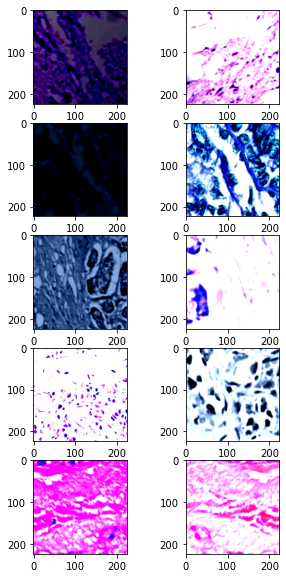

In [123]:
plt.figure(figsize=(5,10))
def view_data(ds, index):
    for i in range(1,6):
        images = ds[i]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(train_ds, 20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

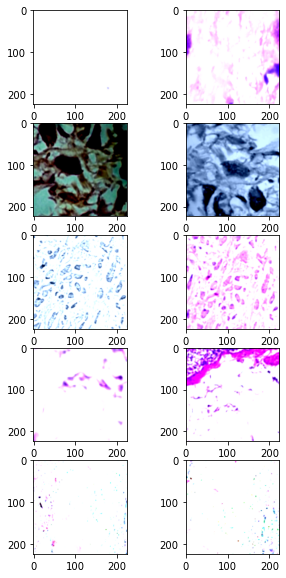

In [124]:
plt.figure(figsize=(5,10))
def view_data(ds, index):
    for i in range(1,6):
        images = ds[i]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(valid_ds, 20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

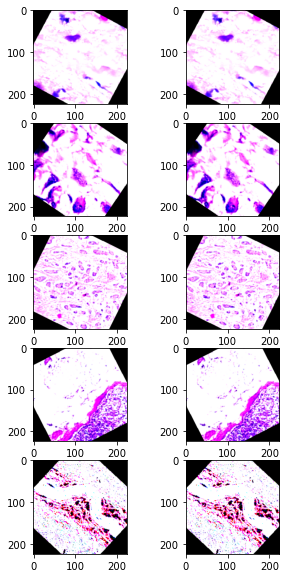

In [126]:
plt.figure(figsize=(5,10))
def view_data(ds, index):
    for i in range(1,6):
        images = ds[i]
        view1, _ = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view1.permute(1,2,0))

view_data(class_valid_ds, 20)

In [127]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)
       
valid_dl = torch.utils.data.DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)


In [128]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x
    
class SimCLRContrastive(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.encoder = backbone
        
        self.projection = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128)
        )
        
    def forward(self, x):

        x = torch.cat(x, dim=0)
        encoding = self.encoder(x)

        projection = self.projection(encoding) 
        return projection

In [129]:
backbone = torchvision.models.resnet50(pretrained = True)
backbone.fc = Identity()

In [130]:

simclr_model = SimCLRContrastive(backbone).to(DEVICE)                       # network model
cont_criterion = nn.CrossEntropyLoss().to(DEVICE)                # loss
cont_optimizer = torch.optim.Adam(simclr_model.parameters(), weight_decay= (10**-6))     # optimizer

In [131]:
simclr_model.encoder

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [132]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

# contrastive loss
def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [133]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  

In [134]:
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [135]:
root = 'Fold_1_5'

In [136]:

import torch
from torch import nn
from torch.optim.optimizer import Optimizer, required

class LARS(Optimizer):
    r"""Extends SGD in PyTorch with LARS scaling from the paper
    `Large batch training of Convolutional Networks <https://arxiv.org/pdf/1708.03888.pdf>`_.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        trust_coefficient (float, optional): trust coefficient for computing LR (default: 0.001)
        eps (float, optional): eps for division denominator (default: 1e-8)

    Example:
        >>> model = nn.Linear(10, 1)
        >>> optimizer = LARS(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> # loss_fn(model(input), target).backward()
        >>> optimizer.step()

    .. note::
        The application of momentum in the SGD part is modified according to
        the PyTorch standards. LARS scaling fits into the equation in the
        following fashion.

        .. math::
            \begin{aligned}
                g_{t+1} & = \text{lars\_lr} * (\beta * p_{t} + g_{t+1}), \\
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}

        where :math:`p`, :math:`g`, :math:`v`, :math:`\mu` and :math:`\beta` denote the
        parameters, gradient, velocity, momentum, and weight decay respectively.
        The :math:`lars_lr` is defined by Eq. 6 in the paper.
        The Nesterov version is analogously modified.

    .. warning::
        Parameters with weight decay set to 0 will automatically be excluded from
        layer-wise LR scaling. This is to ensure consistency with papers like SimCLR
        and BYOL.
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum: float = 0,
        dampening: float = 0,
        weight_decay: float = 0,
        nesterov: bool = False,
        trust_coefficient: float = 0.001,
        eps: float = 1e-8,
    ):
        if lr is not required and lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if momentum < 0.0:
            raise ValueError(f"Invalid momentum value: {momentum}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")

        self.eps = eps
        self.trust_coefficient = trust_coefficient

        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

        for group in self.param_groups:
            group.setdefault("nesterov", False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # exclude scaling for params with 0 weight decay
        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            dampening = group["dampening"]
            nesterov = group["nesterov"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                d_p = p.grad
                p_norm = torch.norm(p.data)
                g_norm = torch.norm(p.grad.data)

                # lars scaling + weight decay part
                if weight_decay != 0:
                    if p_norm != 0 and g_norm != 0:
                        lars_lr = p_norm / (g_norm + p_norm * weight_decay + self.eps)
                        lars_lr *= self.trust_coefficient

                        d_p = d_p.add(p, alpha=weight_decay)
                        d_p *= lars_lr

                # sgd part
                if momentum != 0:
                    param_state = self.state[p]
                    if "momentum_buffer" not in param_state:
                        buf = param_state["momentum_buffer"] = torch.clone(d_p).detach()
                    else:
                        buf = param_state["momentum_buffer"]
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group["lr"])

        return loss


In [137]:
backbone = torchvision.models.resnet50(pretrained = True)
backbone.fc = Identity()
# lr = 0.05*(BATCH_SIZE)/256
lr = 0.075*(BATCH_SIZE**0.5)
print(lr)

simclr_model = SimCLRContrastive(backbone).to(DEVICE)                       
cont_criterion = nn.CrossEntropyLoss().to(DEVICE) 

cont_optimizer = LARS(simclr_model.parameters(), lr = lr, weight_decay= (10**-6))     

scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(cont_optimizer, T_max=1000, 
                                                     eta_min=10**-5, verbose=True)


0.848528137423857
Adjusting learning rate of group 0 to 8.4853e-01.


In [138]:
checkpoint = torch.load(f'../binary classification/saved_models/SimCLR-1-{root}-Contrastive-epoch-100.pth.tar' )
simclr_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [139]:
class SimCLRClassifier(nn.Module):
    def __init__(self,backbone):
        super().__init__()
        self.encoder = backbone
        self.linear = nn.Sequential(
            nn.Dropout(p = 0.6),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(p = 0.6),
            nn.Linear(512, 8))
                           
    def forward(self, x):
        encoding = self.encoder(x).flatten(start_dim=1)
        classification = self.linear(encoding)
        return classification

In [140]:
classifierModel = SimCLRClassifier(backbone).to(DEVICE)

In [141]:
# warm up

In [142]:
for param in classifierModel.encoder.parameters():
    param.requires_grad = False

In [143]:
print(classifierModel.linear[1].weight.requires_grad)
for param in classifierModel.encoder.parameters():
    print(param.requires_grad)

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [144]:
# Building the classification data loader
class_train_ds = ClassificationDataset(
    file_name= base + 'train_80.csv',
)
class_valid_ds = ClassificationDataset(
    file_name= base + 'val_20.csv',
)



In [145]:
print(class_train_ds[16])

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

In [146]:
class_train_dl = torch.utils.data.DataLoader(
    class_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)
    
    
class_valid_dl = torch.utils.data.DataLoader(
    class_valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [147]:
# lr = 0.05*(BATCH_SIZE/256)
lr = 0.075*(BATCH_SIZE**0.5)
print(lr)

classification_criterion = nn.CrossEntropyLoss().to(DEVICE)
classification_optimizer = LARS(classifierModel.parameters(), lr = lr, weight_decay= (10**-6))  

class_scheduler= torch.optim.lr_scheduler.CosineAnnealingLR(classification_optimizer, T_max=1000, 
                                                     eta_min=10**-5, verbose=True)


0.848528137423857
Adjusting learning rate of group 0 to 8.4853e-01.


In [148]:
from tqdm import tqdm
epochs = 5
for epoch in range(epochs):
    accuracies = list()
    class_losses = list()
    classifierModel.train()
    for class_batch in tqdm(class_train_dl):
        x, y = class_batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
       
        logit = classifierModel(x)
        classification_loss = classification_criterion(logit, y)
        class_losses.append(classification_loss.item())

        classifierModel.zero_grad()
        classification_loss.backward()
        classification_optimizer.step()

        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())
    
    class_scheduler.step()

    print(f'Epoch {epoch + 1}')
    print(f'classification training loss: {torch.tensor(class_losses).mean():.5f}')
    print(f'classification training accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')


    losses = list()
    accuracies = list()
    classifierModel.eval()
    for batch in tqdm(class_valid_dl):
        x, y = batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            logit = classifierModel(x)

        loss = classification_criterion(logit, y)

        losses.append(loss.item())
        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())

    print(f'Epoch {epoch + 1}')
    print(f'classification validation loss: {torch.tensor(losses).mean():.5f}')
    print(f'classification validation accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')


100%|███████████████████████████████████████████| 49/49 [00:15<00:00,  3.15it/s]


Adjusting learning rate of group 0 to 8.4853e-01.
Epoch 1
classification training loss: 1.90564
classification training accuracy: 0.33801



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 1
classification validation loss: 1.71578
classification validation accuracy: 0.43945



100%|███████████████████████████████████████████| 49/49 [00:15<00:00,  3.12it/s]


Adjusting learning rate of group 0 to 8.4852e-01.
Epoch 2
classification training loss: 1.75737
classification training accuracy: 0.43750



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 2
classification validation loss: 1.69127
classification validation accuracy: 0.43555



100%|███████████████████████████████████████████| 49/49 [00:16<00:00,  3.05it/s]


Adjusting learning rate of group 0 to 8.4851e-01.
Epoch 3
classification training loss: 1.73575
classification training accuracy: 0.43415



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 3
classification validation loss: 1.65321
classification validation accuracy: 0.43685



100%|███████████████████████████████████████████| 49/49 [00:16<00:00,  3.06it/s]


Adjusting learning rate of group 0 to 8.4849e-01.
Epoch 4
classification training loss: 1.69639
classification training accuracy: 0.44276



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 4
classification validation loss: 1.62776
classification validation accuracy: 0.43685



100%|███████████████████████████████████████████| 49/49 [00:15<00:00,  3.08it/s]


Adjusting learning rate of group 0 to 8.4848e-01.
Epoch 5
classification training loss: 1.67118
classification training accuracy: 0.44882



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]

Epoch 5
classification validation loss: 1.59385
classification validation accuracy: 0.44792



In [149]:
for param in classifierModel.encoder.parameters():
    param.requires_grad = True

In [150]:
print(classifierModel.linear[1].weight.requires_grad)
for param in classifierModel.encoder.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [151]:
# differnt augmentions from contrastive traning

In [152]:
from tqdm import tqdm
epochs = 100
for epoch in range(epochs):
    accuracies = list()
    class_losses = list()
    classifierModel.train()
    for class_batch in tqdm(class_train_dl):
        x, y = class_batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
       
        logit = classifierModel(x)
        classification_loss = classification_criterion(logit, y)
        class_losses.append(classification_loss.item())

        classifierModel.zero_grad()
        classification_loss.backward()
        classification_optimizer.step()

        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())
    
    class_scheduler.step()
    
    if (epoch+1)%10==0:
        checkpoints = { 
                'classifier': classifierModel.state_dict(), 
                'classifier_optimizer': classification_optimizer.state_dict(),
                'epochs': epoch + 1,
              }
        torch.save(checkpoints,f'saved_models/SimCLR-1{root}-Classifier-epoch-{epoch+1}.pth.tar' )
        print(f"saved checkpoint for epoch {epoch + 1}")


    print(f'Epoch {epoch + 1}')
    print(f'classification training loss: {torch.tensor(class_losses).mean():.5f}')
    print(f'classification training accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')
    

    losses = list()
    accuracies = list()
    classifierModel.eval()
    for batch in tqdm(class_valid_dl):
        x, y = batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            logit = classifierModel(x)

        loss = classification_criterion(logit, y)

        losses.append(loss.item())
        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())

    print(f'Epoch {epoch + 1}')
    print(f'classification validation loss: {torch.tensor(losses).mean():.5f}')
    print(f'classification validation accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.4845e-01.
Epoch 1
classification training loss: 1.49726
classification training accuracy: 0.50542



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 1
classification validation loss: 1.25328
classification validation accuracy: 0.54753



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.53it/s]


Adjusting learning rate of group 0 to 8.4843e-01.
Epoch 2
classification training loss: 1.27110
classification training accuracy: 0.55740



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 2
classification validation loss: 1.06952
classification validation accuracy: 0.61589



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4839e-01.
Epoch 3
classification training loss: 1.10467
classification training accuracy: 0.61240



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 3
classification validation loss: 0.91730
classification validation accuracy: 0.69076



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4836e-01.
Epoch 4
classification training loss: 0.93576
classification training accuracy: 0.67522



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 4
classification validation loss: 0.76556
classification validation accuracy: 0.74609



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4832e-01.
Epoch 5
classification training loss: 0.81165
classification training accuracy: 0.71572



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 5
classification validation loss: 0.64998
classification validation accuracy: 0.76953



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4827e-01.
Epoch 6
classification training loss: 0.70839
classification training accuracy: 0.75032



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 6
classification validation loss: 0.57346
classification validation accuracy: 0.79753



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4823e-01.
Epoch 7
classification training loss: 0.62858
classification training accuracy: 0.78013



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 7
classification validation loss: 0.49918
classification validation accuracy: 0.81120



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.4817e-01.
Epoch 8
classification training loss: 0.56065
classification training accuracy: 0.80086



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch 8
classification validation loss: 0.46342
classification validation accuracy: 0.82292



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4812e-01.
Epoch 9
classification training loss: 0.49356
classification training accuracy: 0.82733



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 9
classification validation loss: 0.43714
classification validation accuracy: 0.83464



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4806e-01.
saved checkpoint for epoch 10
Epoch 10
classification training loss: 0.44406
classification training accuracy: 0.84423



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch 10
classification validation loss: 0.39944
classification validation accuracy: 0.84766



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4799e-01.
Epoch 11
classification training loss: 0.39725
classification training accuracy: 0.86320



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 11
classification validation loss: 0.40120
classification validation accuracy: 0.84375



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4792e-01.
Epoch 12
classification training loss: 0.35251
classification training accuracy: 0.87612



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 12
classification validation loss: 0.38322
classification validation accuracy: 0.85807



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4785e-01.
Epoch 13
classification training loss: 0.32956
classification training accuracy: 0.88409



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 13
classification validation loss: 0.31043
classification validation accuracy: 0.87630



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4777e-01.
Epoch 14
classification training loss: 0.30085
classification training accuracy: 0.89573



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch 14
classification validation loss: 0.32086
classification validation accuracy: 0.87240



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4769e-01.
Epoch 15
classification training loss: 0.27346
classification training accuracy: 0.90179



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 15
classification validation loss: 0.31771
classification validation accuracy: 0.88086



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.4761e-01.
Epoch 16
classification training loss: 0.25199
classification training accuracy: 0.90896



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 16
classification validation loss: 0.29484
classification validation accuracy: 0.88542



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4752e-01.
Epoch 17
classification training loss: 0.23105
classification training accuracy: 0.91821



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 17
classification validation loss: 0.30746
classification validation accuracy: 0.88216



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4742e-01.
Epoch 18
classification training loss: 0.21911
classification training accuracy: 0.92427



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 18
classification validation loss: 0.28860
classification validation accuracy: 0.89909



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4732e-01.
Epoch 19
classification training loss: 0.21999
classification training accuracy: 0.92203



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 19
classification validation loss: 0.30081
classification validation accuracy: 0.89062



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4722e-01.
saved checkpoint for epoch 20
Epoch 20
classification training loss: 0.18157
classification training accuracy: 0.93591



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 20
classification validation loss: 0.28622
classification validation accuracy: 0.89714



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4711e-01.
Epoch 21
classification training loss: 0.18307
classification training accuracy: 0.93128



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 21
classification validation loss: 0.27984
classification validation accuracy: 0.89453



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


Adjusting learning rate of group 0 to 8.4700e-01.
Epoch 22
classification training loss: 0.15829
classification training accuracy: 0.94005



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 22
classification validation loss: 0.29896
classification validation accuracy: 0.88997



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4689e-01.
Epoch 23
classification training loss: 0.15855
classification training accuracy: 0.94276



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch 23
classification validation loss: 0.25373
classification validation accuracy: 0.90495



100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


Adjusting learning rate of group 0 to 8.4677e-01.
Epoch 24
classification training loss: 0.14840
classification training accuracy: 0.94531



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch 24
classification validation loss: 0.31593
classification validation accuracy: 0.88346



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.4665e-01.
Epoch 25
classification training loss: 0.15201
classification training accuracy: 0.94165



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 25
classification validation loss: 0.26018
classification validation accuracy: 0.90104



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


Adjusting learning rate of group 0 to 8.4652e-01.
Epoch 26
classification training loss: 0.12741
classification training accuracy: 0.95504



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch 26
classification validation loss: 0.26559
classification validation accuracy: 0.90365



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


Adjusting learning rate of group 0 to 8.4639e-01.
Epoch 27
classification training loss: 0.13286
classification training accuracy: 0.95057



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.79it/s]


Epoch 27
classification validation loss: 0.29609
classification validation accuracy: 0.89323



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4625e-01.
Epoch 28
classification training loss: 0.12388
classification training accuracy: 0.95472



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.91it/s]


Epoch 28
classification validation loss: 0.25555
classification validation accuracy: 0.90625



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4611e-01.
Epoch 29
classification training loss: 0.11459
classification training accuracy: 0.95775



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 29
classification validation loss: 0.26348
classification validation accuracy: 0.90560



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4597e-01.
saved checkpoint for epoch 30
Epoch 30
classification training loss: 0.10725
classification training accuracy: 0.95886



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 30
classification validation loss: 0.25679
classification validation accuracy: 0.90430



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4582e-01.
Epoch 31
classification training loss: 0.10540
classification training accuracy: 0.95950



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 31
classification validation loss: 0.26269
classification validation accuracy: 0.90430



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4567e-01.
Epoch 32
classification training loss: 0.10191
classification training accuracy: 0.96476



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.79it/s]


Epoch 32
classification validation loss: 0.23711
classification validation accuracy: 0.91276



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4551e-01.
Epoch 33
classification training loss: 0.10689
classification training accuracy: 0.96014



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch 33
classification validation loss: 0.28070
classification validation accuracy: 0.90365



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4535e-01.
Epoch 34
classification training loss: 0.09245
classification training accuracy: 0.96317



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 34
classification validation loss: 0.27547
classification validation accuracy: 0.90169



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.4518e-01.
Epoch 35
classification training loss: 0.09795
classification training accuracy: 0.95982



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 35
classification validation loss: 0.27756
classification validation accuracy: 0.90560



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4501e-01.
Epoch 36
classification training loss: 0.09609
classification training accuracy: 0.96445



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 36
classification validation loss: 0.26753
classification validation accuracy: 0.89909



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.4484e-01.
Epoch 37
classification training loss: 0.09213
classification training accuracy: 0.96349



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.90it/s]


Epoch 37
classification validation loss: 0.23789
classification validation accuracy: 0.90690



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.4466e-01.
Epoch 38
classification training loss: 0.08605
classification training accuracy: 0.96684



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 38
classification validation loss: 0.33316
classification validation accuracy: 0.89388



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4448e-01.
Epoch 39
classification training loss: 0.08837
classification training accuracy: 0.96747



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 39
classification validation loss: 0.26629
classification validation accuracy: 0.90234



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4430e-01.
saved checkpoint for epoch 40
Epoch 40
classification training loss: 0.08241
classification training accuracy: 0.96684



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 40
classification validation loss: 0.27768
classification validation accuracy: 0.90885



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4411e-01.
Epoch 41
classification training loss: 0.07925
classification training accuracy: 0.97003



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch 41
classification validation loss: 0.27323
classification validation accuracy: 0.90951



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4391e-01.
Epoch 42
classification training loss: 0.07085
classification training accuracy: 0.97162



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 42
classification validation loss: 0.24958
classification validation accuracy: 0.91732



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4371e-01.
Epoch 43
classification training loss: 0.06966
classification training accuracy: 0.97210



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 43
classification validation loss: 0.27046
classification validation accuracy: 0.90755



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4351e-01.
Epoch 44
classification training loss: 0.07155
classification training accuracy: 0.97178



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.90it/s]


Epoch 44
classification validation loss: 0.31605
classification validation accuracy: 0.90169



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4330e-01.
Epoch 45
classification training loss: 0.06712
classification training accuracy: 0.97353



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 45
classification validation loss: 0.31545
classification validation accuracy: 0.90755



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4309e-01.
Epoch 46
classification training loss: 0.06679
classification training accuracy: 0.97305



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 46
classification validation loss: 0.26141
classification validation accuracy: 0.91862



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4288e-01.
Epoch 47
classification training loss: 0.06142
classification training accuracy: 0.97337



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.90it/s]


Epoch 47
classification validation loss: 0.31186
classification validation accuracy: 0.90039



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.4266e-01.
Epoch 48
classification training loss: 0.06415
classification training accuracy: 0.97369



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 48
classification validation loss: 0.27976
classification validation accuracy: 0.91276



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4244e-01.
Epoch 49
classification training loss: 0.06109
classification training accuracy: 0.97417



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 49
classification validation loss: 0.25553
classification validation accuracy: 0.91732



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.4221e-01.
saved checkpoint for epoch 50
Epoch 50
classification training loss: 0.06174
classification training accuracy: 0.97481



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 50
classification validation loss: 0.30919
classification validation accuracy: 0.90495



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4198e-01.
Epoch 51
classification training loss: 0.06314
classification training accuracy: 0.97305



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch 51
classification validation loss: 0.28623
classification validation accuracy: 0.91146



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4174e-01.
Epoch 52
classification training loss: 0.05677
classification training accuracy: 0.97497



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 52
classification validation loss: 0.27241
classification validation accuracy: 0.90951



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.47it/s]


Adjusting learning rate of group 0 to 8.4150e-01.
Epoch 53
classification training loss: 0.05939
classification training accuracy: 0.97321



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch 53
classification validation loss: 0.28101
classification validation accuracy: 0.91536



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4126e-01.
Epoch 54
classification training loss: 0.06035
classification training accuracy: 0.97401



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch 54
classification validation loss: 0.29676
classification validation accuracy: 0.90755



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.4101e-01.
Epoch 55
classification training loss: 0.05834
classification training accuracy: 0.97497



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 55
classification validation loss: 0.27843
classification validation accuracy: 0.90625



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4076e-01.
Epoch 56
classification training loss: 0.05582
classification training accuracy: 0.97577



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 56
classification validation loss: 0.30547
classification validation accuracy: 0.90951



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.4051e-01.
Epoch 57
classification training loss: 0.04854
classification training accuracy: 0.97704



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 57
classification validation loss: 0.32770
classification validation accuracy: 0.91341



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.4025e-01.
Epoch 58
classification training loss: 0.05454
classification training accuracy: 0.97449



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 58
classification validation loss: 0.28077
classification validation accuracy: 0.90560



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.3998e-01.
Epoch 59
classification training loss: 0.05005
classification training accuracy: 0.97704



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 59
classification validation loss: 0.30231
classification validation accuracy: 0.91732



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.3971e-01.
saved checkpoint for epoch 60
Epoch 60
classification training loss: 0.05268
classification training accuracy: 0.97608



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 60
classification validation loss: 0.32684
classification validation accuracy: 0.90234



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.3944e-01.
Epoch 61
classification training loss: 0.05111
classification training accuracy: 0.97688



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 61
classification validation loss: 0.31469
classification validation accuracy: 0.90690



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3916e-01.
Epoch 62
classification training loss: 0.04774
classification training accuracy: 0.98007



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch 62
classification validation loss: 0.28871
classification validation accuracy: 0.91276



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3888e-01.
Epoch 63
classification training loss: 0.05282
classification training accuracy: 0.97720



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 63
classification validation loss: 0.28169
classification validation accuracy: 0.91276



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3860e-01.
Epoch 64
classification training loss: 0.05110
classification training accuracy: 0.97688



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 64
classification validation loss: 0.28406
classification validation accuracy: 0.91667



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.3831e-01.
Epoch 65
classification training loss: 0.04476
classification training accuracy: 0.97991



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 65
classification validation loss: 0.27720
classification validation accuracy: 0.91602



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.3802e-01.
Epoch 66
classification training loss: 0.04627
classification training accuracy: 0.97911



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 66
classification validation loss: 0.37647
classification validation accuracy: 0.89583



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3772e-01.
Epoch 67
classification training loss: 0.04511
classification training accuracy: 0.97832



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 67
classification validation loss: 0.32428
classification validation accuracy: 0.91406



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3742e-01.
Epoch 68
classification training loss: 0.04363
classification training accuracy: 0.98023



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 68
classification validation loss: 0.33160
classification validation accuracy: 0.91016



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.3711e-01.
Epoch 69
classification training loss: 0.04430
classification training accuracy: 0.97895



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 69
classification validation loss: 0.34123
classification validation accuracy: 0.90560



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3681e-01.
saved checkpoint for epoch 70
Epoch 70
classification training loss: 0.04292
classification training accuracy: 0.97975



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 70
classification validation loss: 0.30254
classification validation accuracy: 0.91146



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3649e-01.
Epoch 71
classification training loss: 0.04820
classification training accuracy: 0.98023



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 71
classification validation loss: 0.34200
classification validation accuracy: 0.90430



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3618e-01.
Epoch 72
classification training loss: 0.04449
classification training accuracy: 0.98055



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 72
classification validation loss: 0.34421
classification validation accuracy: 0.91146



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.3585e-01.
Epoch 73
classification training loss: 0.04541
classification training accuracy: 0.97848



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch 73
classification validation loss: 0.32331
classification validation accuracy: 0.91732



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.3553e-01.
Epoch 74
classification training loss: 0.04584
classification training accuracy: 0.97943



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 74
classification validation loss: 0.38498
classification validation accuracy: 0.91081



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.3520e-01.
Epoch 75
classification training loss: 0.04290
classification training accuracy: 0.97991



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 75
classification validation loss: 0.28701
classification validation accuracy: 0.91992



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.3487e-01.
Epoch 76
classification training loss: 0.03724
classification training accuracy: 0.98214



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 76
classification validation loss: 0.33006
classification validation accuracy: 0.91536



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.3453e-01.
Epoch 77
classification training loss: 0.04249
classification training accuracy: 0.97911



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch 77
classification validation loss: 0.31465
classification validation accuracy: 0.92773



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3419e-01.
Epoch 78
classification training loss: 0.04465
classification training accuracy: 0.97816



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 78
classification validation loss: 0.28474
classification validation accuracy: 0.91406



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3384e-01.
Epoch 79
classification training loss: 0.04449
classification training accuracy: 0.98023



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 79
classification validation loss: 0.32449
classification validation accuracy: 0.91927



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3349e-01.
saved checkpoint for epoch 80
Epoch 80
classification training loss: 0.04072
classification training accuracy: 0.97975



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 80
classification validation loss: 0.28620
classification validation accuracy: 0.91927



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.3314e-01.
Epoch 81
classification training loss: 0.03933
classification training accuracy: 0.98103



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 81
classification validation loss: 0.29229
classification validation accuracy: 0.92122



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


Adjusting learning rate of group 0 to 8.3278e-01.
Epoch 82
classification training loss: 0.03823
classification training accuracy: 0.98198



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 82
classification validation loss: 0.29655
classification validation accuracy: 0.92253



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3242e-01.
Epoch 83
classification training loss: 0.03861
classification training accuracy: 0.98166



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 83
classification validation loss: 0.29538
classification validation accuracy: 0.91667



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3205e-01.
Epoch 84
classification training loss: 0.03855
classification training accuracy: 0.98278



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 84
classification validation loss: 0.29793
classification validation accuracy: 0.91667



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.3168e-01.
Epoch 85
classification training loss: 0.03423
classification training accuracy: 0.98469



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 85
classification validation loss: 0.34680
classification validation accuracy: 0.91146



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.3131e-01.
Epoch 86
classification training loss: 0.04157
classification training accuracy: 0.98103



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 86
classification validation loss: 0.35132
classification validation accuracy: 0.91471



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.3093e-01.
Epoch 87
classification training loss: 0.03960
classification training accuracy: 0.98071



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch 87
classification validation loss: 0.34608
classification validation accuracy: 0.91536



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.3055e-01.
Epoch 88
classification training loss: 0.03350
classification training accuracy: 0.98071



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 88
classification validation loss: 0.32704
classification validation accuracy: 0.91732



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.3016e-01.
Epoch 89
classification training loss: 0.04036
classification training accuracy: 0.97975



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 89
classification validation loss: 0.29666
classification validation accuracy: 0.92057



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.2977e-01.
saved checkpoint for epoch 90
Epoch 90
classification training loss: 0.03579
classification training accuracy: 0.98262



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 90
classification validation loss: 0.32334
classification validation accuracy: 0.91862



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.2938e-01.
Epoch 91
classification training loss: 0.03300
classification training accuracy: 0.98246



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch 91
classification validation loss: 0.29042
classification validation accuracy: 0.92513



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.2898e-01.
Epoch 92
classification training loss: 0.03482
classification training accuracy: 0.98230



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 92
classification validation loss: 0.35658
classification validation accuracy: 0.91146



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Adjusting learning rate of group 0 to 8.2858e-01.
Epoch 93
classification training loss: 0.04205
classification training accuracy: 0.98055



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch 93
classification validation loss: 0.32411
classification validation accuracy: 0.92253



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.2817e-01.
Epoch 94
classification training loss: 0.03449
classification training accuracy: 0.98278



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch 94
classification validation loss: 0.36159
classification validation accuracy: 0.91406



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.2776e-01.
Epoch 95
classification training loss: 0.03559
classification training accuracy: 0.98119



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch 95
classification validation loss: 0.34116
classification validation accuracy: 0.91146



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.2735e-01.
Epoch 96
classification training loss: 0.03880
classification training accuracy: 0.98166



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 96
classification validation loss: 0.36150
classification validation accuracy: 0.91536



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.49it/s]


Adjusting learning rate of group 0 to 8.2693e-01.
Epoch 97
classification training loss: 0.03946
classification training accuracy: 0.97864



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 97
classification validation loss: 0.29853
classification validation accuracy: 0.91927



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.2651e-01.
Epoch 98
classification training loss: 0.03409
classification training accuracy: 0.98214



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 98
classification validation loss: 0.28107
classification validation accuracy: 0.92318



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


Adjusting learning rate of group 0 to 8.2608e-01.
Epoch 99
classification training loss: 0.03170
classification training accuracy: 0.98453



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch 99
classification validation loss: 0.31287
classification validation accuracy: 0.92513



100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


Adjusting learning rate of group 0 to 8.2565e-01.
saved checkpoint for epoch 100
Epoch 100
classification training loss: 0.03195
classification training accuracy: 0.98517



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.82it/s]

Epoch 100
classification validation loss: 0.34008
classification validation accuracy: 0.92253



In [153]:
target_names = list(labelMap.keys())
print(target_names)

['A', 'DC', 'F', 'LC', 'MC', 'PC', 'PT', 'TA']


In [154]:
from sklearn.metrics import classification_report

In [155]:
from tqdm import tqdm
true_labels = []
predicted_labels = []
classifierModel.eval()
for batch in tqdm(class_valid_dl):
    x, y = batch
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():
        logit = classifierModel(x)

    prediction = logit.detach().argmax(dim =1)

    true_labels += y.tolist()
    predicted_labels += prediction.tolist()

100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.83it/s]


In [156]:
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           A       0.95      0.98      0.96        88
          DC       0.94      0.94      0.94       665
           F       0.94      0.93      0.93       198
          LC       0.76      0.74      0.75       123
          MC       0.89      0.97      0.93       153
          PC       0.93      0.91      0.92       107
          PT       0.91      0.86      0.88        90
          TA       0.97      0.96      0.97       112

    accuracy                           0.92      1536
   macro avg       0.91      0.91      0.91      1536
weighted avg       0.92      0.92      0.92      1536

